In [1]:
import warnings
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")

In [4]:
class BiLSTM(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        num_classes: int,
        device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0"),
    ):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )
        # multiple hidden size by two for one going forward and the other backwards
        # which will then be concatenated
        self.fc = nn.Linear(hidden_size*2, num_classes)
        
    def forward(self, x):
        # initialize the hidden layer
        # multiple num layers by two for one going forward and the other backwards
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        
        # forward prop
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1,:]) # use the last hidden state
        # out = self.fc(out)
        return out
    

In [5]:
# Hyper parameters
input_size = 28
num_layers = 2
hidden_size = 256
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 1

In [6]:
# load data
train_dataset = datasets.MNIST(root='../dataset/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='../dataset/', train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
model = BiLSTM(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    num_classes=num_classes,
).to(device)
# loss functions
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Put the model in training mode
model.train()

BiLSTM(
  (lstm): LSTM(28, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [8]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # set the data to device
        data = data.to(device).squeeze(1)
        targets = targets.to(device)
        
        scores = model(data)
        loss = criterion(scores, targets)
        # backward
        optimizer.zero_grad() # set all gradients to zero for each batch to avoid storing batch forward calculation
        loss.backward()
        # gradient descent or adam step
        optimizer.step() 
        # add the training loss to the train loses
        train_losses.append(loss.item())
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # set the model to validation mode
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device).squeeze(1)
                y = y.to(device)
                prediction = model(x)
                val_loss += criterion(prediction, y).item()
        
        val_loss /= len(test_loader)  # Average validation loss
        val_losses.append(val_loss)
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

print("Training and validation completed.")

Epoch [1/1], Step [0/938], Loss: 2.2997
Epoch [1/1], Validation Loss: 2.3022
Epoch [1/1], Step [100/938], Loss: 0.7260
Epoch [1/1], Validation Loss: 0.7755
Epoch [1/1], Step [200/938], Loss: 0.3934
Epoch [1/1], Validation Loss: 0.6280
Epoch [1/1], Step [300/938], Loss: 0.1425
Epoch [1/1], Validation Loss: 0.2749
Epoch [1/1], Step [400/938], Loss: 0.2805
Epoch [1/1], Validation Loss: 0.2231
Epoch [1/1], Step [500/938], Loss: 0.2080
Epoch [1/1], Validation Loss: 0.2012
Epoch [1/1], Step [600/938], Loss: 0.2516
Epoch [1/1], Validation Loss: 0.2897
Epoch [1/1], Step [700/938], Loss: 0.2434
Epoch [1/1], Validation Loss: 0.1645
Epoch [1/1], Step [800/938], Loss: 0.1595
Epoch [1/1], Validation Loss: 0.1697
Epoch [1/1], Step [900/938], Loss: 0.1135
Epoch [1/1], Validation Loss: 0.1161
Training and validation completed.


In [9]:
model_path = f"../models/bi_lstm.pth"

In [10]:
# save the model
torch.save(model.state_dict(), model_path)

In [11]:
model.load_state_dict(torch.load(model_path))
model.eval()

BiLSTM(
  (lstm): LSTM(28, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [12]:
x = np.arange(1, len(train_losses) + 1)

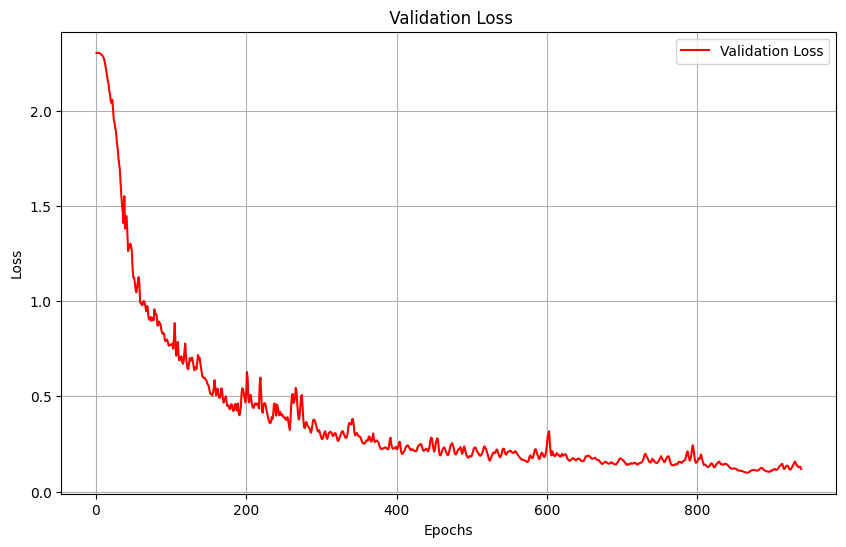

In [13]:
# plot the validation loss
plt.figure(figsize=(10, 6))
plt.plot(x, val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(" Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

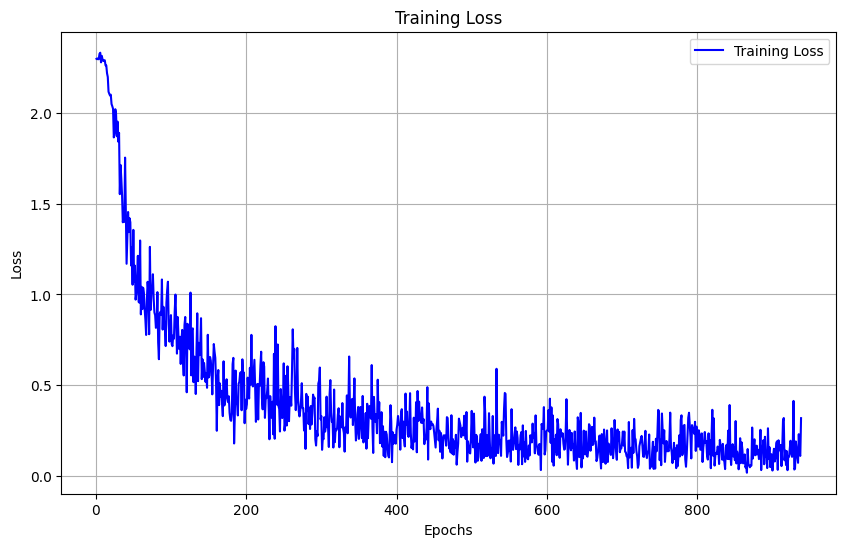

In [14]:
# plot the training
plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()

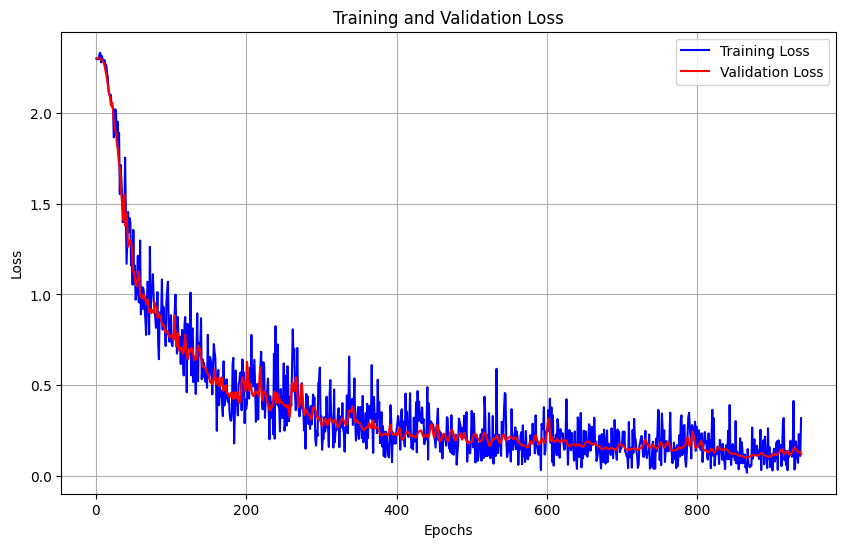

In [15]:
# plot the training and validation loss 
plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label="Training Loss", color='blue')
plt.plot(x, val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

In [16]:
# check for the accuracy of the model
def check_accuracy(loader, trained_model):
    num_correct = 0
    num_samples = 0
    trained_model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device).squeeze(1)
            y = y.to(device)
            pred_scores = trained_model(x)
            _, predictions = pred_scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
    print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100}")
    print(f"Accuracy: {float(num_correct)/float(num_samples)*100}")

In [17]:
check_accuracy(test_loader, model)

Got 9642 / 10000 with accuracy 96.41999999999999
Accuracy: 96.41999999999999
